## Libraries

In [ ]:
!pip install numpy pandas librosa matplotlib seaborn scikit-learn keras resampy


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, BatchNormalization, Dropout,
                                     Flatten, Dense, LSTM, Bidirectional, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf


# from keras_focal_loss import categorical_focal_loss?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Import

In [ ]:
speech_path = '/content/drive/MyDrive/mars/Audio_Speech_Actors_01-24'
song_path = '/content/drive/MyDrive/mars/Audio_Song_Actors_01-24'


## Focal Loss

In [ ]:
def categorical_focal_loss(gamma=2., alpha=.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss


## Emotion Mapping

In [ ]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


## Extract Features

In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5, sr=22050)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60, hop_length=512)
    target_length = 130
    if mfcc.shape[1] < target_length:
        pad_width = target_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :target_length]
    return mfcc.T

In [ ]:
features = []

print("Starting Feature Extraction Process...\n")

print("Processing Speech Files...")
for folder in os.listdir(speech_path):
    print(f"Processing Speech Actor Folder: {folder}")
    for file in os.listdir(os.path.join(speech_path, folder)):
        file_path = os.path.join(speech_path, folder, file)
        emotion_label = emotion_dict[file.split('-')[2]]
        
        features.append([extract_features(file_path), emotion_label])

print("\nFinished processing Speech Files.\n")

print("Processing Song Files...")
for folder in os.listdir(song_path):
    print(f"Processing Song Actor Folder: {folder}")
    for file in os.listdir(os.path.join(song_path, folder)):
        file_path = os.path.join(song_path, folder, file)
        emotion_label = emotion_dict[file.split('-')[2]]
        
        features.append([extract_features(file_path), emotion_label])

print("\nFinished processing Song Files.\n")

print("Creating DataFrame from extracted features...")
df = pd.DataFrame(features, columns=['feature', 'emotion'])
print("DataFrame created successfully!")
print(f"Total samples: {len(df)}\n")

Starting Feature Extraction Process...

Processing Speech Files...
Processing Speech Actor Folder: Actor_05
Processing Speech Actor Folder: Actor_03
Processing Speech Actor Folder: Actor_09
Processing Speech Actor Folder: Actor_06
Processing Speech Actor Folder: Actor_08
Processing Speech Actor Folder: Actor_04
Processing Speech Actor Folder: Actor_02
Processing Speech Actor Folder: Actor_01
Processing Speech Actor Folder: Actor_07
Processing Speech Actor Folder: Actor_11
Processing Speech Actor Folder: Actor_16
Processing Speech Actor Folder: Actor_17
Processing Speech Actor Folder: Actor_12
Processing Speech Actor Folder: Actor_18
Processing Speech Actor Folder: Actor_14
Processing Speech Actor Folder: Actor_15
Processing Speech Actor Folder: Actor_13
Processing Speech Actor Folder: Actor_10
Processing Speech Actor Folder: Actor_19
Processing Speech Actor Folder: Actor_20
Processing Speech Actor Folder: Actor_24
Processing Speech Actor Folder: Actor_22
Processing Speech Actor Folder:

## Encoding

In [ ]:
X = np.array([i for i in df['feature']])
y = np.array(df['emotion'].tolist())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)
print("Classes:", label_encoder.classes_)

Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
#split
X = np.array([i for i in df['feature']])
y = np.array(df['emotion'].tolist())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Scale
num_samples_train, time_steps, n_mfcc = X_train.shape
X_train_flat = X_train.reshape(num_samples_train * time_steps, n_mfcc)


scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(num_samples_train, time_steps, n_mfcc)

num_samples_test = X_test.shape[0]
X_test_flat = X_test.reshape(num_samples_test * time_steps, n_mfcc)
X_test_scaled_flat = scaler.transform(X_test_flat)  # Only transform, don't fit
X_test_scaled = X_test_scaled_flat.reshape(num_samples_test, time_steps, n_mfcc)

print("Classes:", label_encoder.classes_)
print("Training shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

## Class Weight

In [ ]:
y_train_encoded = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

## Data augmentation

In [ ]:
def augment_feature_array(X, y, label_encoder):
    """
    Augment features selectively for 'happy' and 'sad' classes.
    Returns augmented X and y arrays.
    """
    X_augmented = []
    y_augmented = []

    for i in range(len(X)):
        label_idx = np.argmax(y[i])
        label = label_encoder.classes_[label_idx]
        
        if label in ['happy', 'sad']:
            
            augmented_feature = X[i] + np.random.normal(0, 0.01, X[i].shape)
            X_augmented.append(augmented_feature)
            y_augmented.append(y[i])


    if len(X_augmented) > 0:
        X_combined = np.concatenate([X, np.array(X_augmented)], axis=0)
        y_combined = np.concatenate([y, np.array(y_augmented)], axis=0)
    else:
        X_combined = X
        y_combined = y

    return X_combined, y_combined


X_train_aug, y_train_aug = augment_feature_array(X_train_scaled, y_train, label_encoder)

print("Data Augmentation applied")
print("Original training samples:", X_train_scaled.shape[0])
print("Augmented training samples:", X_train_aug.shape[0])

## Model

In [ ]:
num_classes = y_cat.shape[1]
model = Sequential([
    Conv1D(128, 5, padding='same', activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    BatchNormalization(), MaxPooling1D(2), Dropout(0.3),

    Conv1D(64, 5, padding='same', activation='relu'),
    BatchNormalization(), MaxPooling1D(2), Dropout(0.3),

    Conv1D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),

    Bidirectional(LSTM(128, return_sequences=True)), Dropout(0.3),
    Bidirectional(LSTM(64)), Dropout(0.3),

    Dense(128, activation='relu'), Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(5e-4),
              loss=categorical_focal_loss(gamma=2),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 130, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 65, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,384 (1.65 MB)

 Trainable params: 432,936 (1.65 MB)

 Non-trainable params: 448 (1.75 KB)

## Training

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [ ]:
history = model.fit(
    X_train_aug, y_train_aug,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.2736 - loss: 0.3388 - val_accuracy: 0.5392 - val_loss: 0.1893 - learning_rate: 5.0000e-04
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5837 - loss: 0.1713 - val_accuracy: 0.6544 - val_loss: 0.1286 - learning_rate: 5.0000e-04
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6422 - loss: 0.1362 - val_accuracy: 0.6595 - val_loss: 0.1193 - learning_rate: 5.0000e-04
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6994 - loss: 0.1145 - val_accuracy: 0.6983 - val_loss: 0.0983 - learning_rate: 5.0000e-04
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7214 - loss: 0.0969 - val_accuracy: 0.7034 - val_loss: 0.1171 - learning_rate: 5.0000e-04
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7495 - loss: 0.0853 - val_accuracy: 0.7034 - val_loss: 0.1094 - learning_rate: 5.0000e-04
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/st

## Eval

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9466 - loss: 0.0220
Test Accuracy: 94.90%
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.95      0.96       150
        calm       0.99      0.95      0.97       151
     disgust       0.96      0.95      0.95        77
     fearful       0.95      0.95      0.95       150
       happy       0.97      0.91      0.94       150
     neutral       0.95      0.96      0.95        75
         sad       0.91      0.96      0.94       151
   surprised       0.89      0.97      0.93        77

    accuracy                           0.95       981
   macro avg       0.95      0.95      0.95       981
weighted avg       0.95      0.95      0.95       981

Confusion Matrix:
[[143   0   1   2   0   0   0   4]
 [  0 144   0   0   0   1   6   0]
 [  2   0  73   0   0   0   2   0]
 [  0   0   0 142   2   0   6   0]
 [  4   0   2   1 137   2   0   4

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9466 - loss: 0.0220
Test Accuracy: 94.90%


In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate the trained model and generate comprehensive metrics
    """
    print("Evaluating model performance...")

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')
    f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')

    print(f"Weighted F1 Score: {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
    print(f"Macro F1 Score: {f1_macro:.4f} ({f1_macro*100:.2f}%)")

    # Detailed Classification Report
    emotion_names = label_encoder.classes_
    class_report = classification_report(
        y_true_classes, y_pred_classes,
        target_names=emotion_names,
        output_dict=True
    )

    print("\n ____Detailed Classification Report:____")
    print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_names))

    # Evaluation Criteria Check
    print("\n" + "="*50)
    print("EVALUATION CRITERIA CHECK:")
    print("="*50)

    meets_f1_requirement = f1_weighted >= 0.80
    meets_accuracy_requirement = accuracy >= 0.80

    print(f"Weighted F1 Score > 80%: {'PASS' if meets_f1_requirement else 'FAIL'} ({f1_weighted*100:.2f}%)")
    print(f"Overall Accuracy > 80%: {'PASS' if meets_accuracy_requirement else 'FAIL'} ({accuracy*100:.2f}%)")

    # Individual Class Accuracies
    class_accuracies_pass = True
    print("\n Individual Class Recalls:")
    for i, emotion in enumerate(emotion_names):
        class_recall = class_report[emotion]['recall']
        passes = class_recall >= 0.75
        if not passes:
            class_accuracies_pass = False
        print(f"  {emotion}: {class_recall*100:.2f}% {'PASS' if passes else 'FAIL'}")

    print(f"\nAll Class Recalls > 75%: {'PASS' if class_accuracies_pass else 'FAIL'}")

    overall_pass = meets_f1_requirement and meets_accuracy_requirement and class_accuracies_pass
    print(f"\nOVERALL EVALUATION: {'PASS' if overall_pass else 'FAIL'}")

    return y_pred_classes, y_true_classes, class_report

print("Evaluation function defined!")


Evaluation function defined!


In [ ]:
y_pred_classes, y_true_classes, class_report = evaluate_model(model, X_test, y_test, label_encoder)


Evaluating model performance...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Overall Test Accuracy: 0.9052 (90.52%)
✅ Weighted F1 Score: 0.9053 (90.53%)
✅ Macro F1 Score: 0.9075 (90.75%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.91      0.94       150
        calm       0.86      0.89      0.88       151
     disgust       0.90      0.94      0.92        77
     fearful       0.89      0.96      0.93       150
       happy       0.95      0.86      0.90       150
     neutral       0.94      0.89      0.92        75
         sad       0.86      0.88      0.87       151
   surprised       0.91      0.92      0.92        77

    accuracy                           0.91       981
   macro avg       0.91      0.91      0.91       981
weighted avg       0.91      0.91      0.91       981


🎯 EVALUATION CRITERIA CHECK:
✔️ Weighted F1 Score > 80%: PASS ✅ (90.53%)
✔️ Overall Accuracy > 80%: PASS ✅ (90.52%)

🔍 Individual 

Training history plotting function defined!


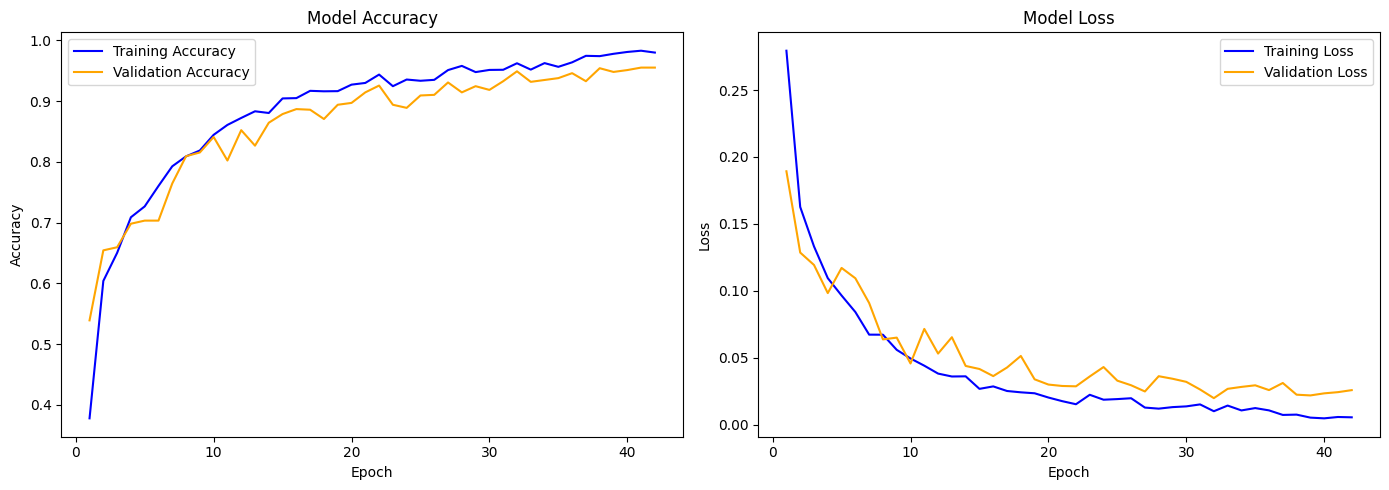

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation accuracy & loss curves.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Training history plotting function defined!")
plot_training_history(history)


## Save model

In [ ]:
import joblib

save_path = '/content/drive/MyDrive/mars'

model.save(f'{save_path}/emotion_model.h5')

# Save preprocessing objects
joblib.dump(scaler, f'{save_path}/scaler.pkl')
joblib.dump(label_encoder, f'{save_path}/label_encoder.pkl')

print(f"Model and artifacts saved in '{save_path}' directory!")


Model and artifacts saved in '/content/drive/MyDrive/mars' directory!


In [ ]:
model.save(f'{save_path}/emotion_model.keras')